# Illustrative notebook : From Linear Thompson Sampling to Neural Thompson Sampling 

We advise you to download our libraries available in the github (.py file), put them on a file in your drive and use Google colab' for the computations.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/RonyAbecidan/NeuralTS/blob/main/Experiments/From_LinearTS_to_NeuralTS.ipynb)

In the paper studied, the authors have worked on the famous contextual bandit problem. In this problem, we consider that we have an agent which has to make sequential choices based on some **contexts** (also called **arms**) from its environment at each round. Each choice leads to a certain **reward** linked to the chosen context vector and, the final goal of the agent is to find this link so that it can maximize its total reward. 


To be more precise, the authors have chosen to broached a rather general version of this problem considering that the context vectors at each round are changing and the link between the contexts and rewards can be made by any bounded mapping. However, the number of contexts per round stays constant as we usually see in the litterature.

In this notebook, we propose in a first part to talk about the possibilities and limitations of LinearTS. Then, we will see to what extent a neural network could help us to obtain a more efficient strategy in the general case. At last, we will study the NeuralTS algorithm that made the link between deep learning methods and the Thompson Sampling strategy.

In [3]:
# %load_ext autoreload
# %autoreload 2

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
import pickle
import os 
import warnings
# from DPWE import *
warnings.filterwarnings('ignore')

# from google.colab import drive

# drive.mount('/content/drive')
## you need to put here the path of your working directory containing our libraries
# os.chdir('drive/MyDrive/NeuralTS')

In [1]:
from BanditTools import *
from BanditBaselines import *
from BanditGenerator import *
from Arms import *
from StochasticBandit import *
from BanditGenerator import *
from Experiments import * 
from NeuralTS import *

In [2]:
from LTS import LTS
from models import LinearModel

model = LinearModel(10, 1)
criterion = nn.MSELoss(reduction='sum')

## I - The limitations of LinearTS

#### Here, we propose to study the limitations of the algorithm LinearTS we have seen in class where the function $h$ is non linear.  We will consider through this section a scenario where there are $K$ arms fixed.

#### Intuitively, we can think that, even when the mean reward $r(x)$ is not a linear function of x, the LinearTS algorithm could still work efficiently and better than the methods that doesn't exploit the features. 

#### We can see it easily thinking about the condition on the context vectors we asked for using this algorithm ($||x|| \leq 1$). 

#### Due that condition, if we consider large vectors in dimension $d$, we should end doing this normalization with vectors made of rather small coefficients. Hence, if our reward is a function that can be approximately equal to a linear function around 0, the LinearTS could work.

We propose to test it with $f_1(x) = \frac{1}{d}\sum_{i=1}^{d} \sin(x_i)$ and $f_2(x) = \frac{1}{d}\sum_{i=1}^{d} (e^{x_i}-1)$, $K=20$ and $d=10$

The bandit generators are available in the library `BanditGenerator.py`


In [4]:
K=20
d=10

#Generation of normalized features - ||x|| <= 1
X = torch.randn((K,d))
norms=torch.Tensor([torch.norm(x) for x in X])
X=X/torch.max(norms).item()

SinB=SinBandit(X)
ExpB=ExpBandit(X)

# print the means of the best two arms
print(np.sort(SinB.means)[-2:])
print(np.sort(ExpB.means)[-2:])

with open(f'X_{K}_{d}.pickle', 'wb') as setting:
    pickle.dump(X, setting)

[0.09694015 0.12185981]
[0.13777485 0.147154  ]


In [5]:
# load the pickle file
K=[20]
d=[10]

for K,d in zip(K,d):
    with open(f'X_{K}_{d}.pickle', 'rb') as setting:
        X=pickle.load(setting)
        SinB=SinBandit(X)
        ExpB=ExpBandit(X)
        #We display the means of the arms by ascending order
        print(f'Contextual MAB K={K} d={d}')
        print('\n')
        print('SinB')
        print(np.sort(SinB.means))
        print('\n')
        print('ExpB')
        print(np.sort(ExpB.means))

Contextual MAB K=20 d=10


SinB
[-0.21491396 -0.08901794 -0.07575963 -0.06740617 -0.06135801 -0.05475281
 -0.04285002 -0.00539179  0.00476461  0.01301448  0.01353815  0.01356996
  0.0151942   0.03005022  0.03872582  0.05350755  0.06191707  0.09390725
  0.09694015  0.12185981]


ExpB
[-0.18310194 -0.07543186 -0.05653317 -0.05394408 -0.03944177 -0.02833851
 -0.01672257  0.01419301  0.01554661  0.0157043   0.02004318  0.02546216
  0.02844797  0.03947678  0.07289045  0.07748734  0.10880306  0.12109313
  0.13777485  0.147154  ]


#### This configuration seems to be nice. We have two reasonably complex MAB problems. Now, let's see how good will be the LinearTS algorithm against other strategy we have discussed in class.





In [6]:
sigma=0.5
nu=sigma
beta_heuri= lambda t:sigma*np.sqrt(d*log(t))
alpha=2*(sigma**2) 
Nexp=20
T=4000

In [9]:
strategy0 = FTL(K)
strategy1 = UCB(K,alpha)
strategy2 = LinUCB(X,beta_heuri)
strategy3 = LinTS(X,nu)
strategy4 = LTS(model, torch.tensor(X).to(device), criterion)

plt.figure(figsize=(10,5))
RunExpes([strategy0,strategy1,strategy2,strategy3, strategy4],SinB,Nexp,T,10,"off")
plt.title('Estimated mean regret through the time for the SinB problem');

TypeError: 'str' object is not callable

<Figure size 720x360 with 0 Axes>

#### As expected, the LinTS algorithm performs well even in a case where the mean reward function is not linear (We observe a sublinear regret). However, the LinUCB which is based on the same assumption is worst than FTL here. How can we explain that ? Technically, the LinTS algorithm takes into account a kind of randomness of the parameter $\theta$ to estimate and, sample it from its estimated posterior. Hence, maybe the slight modification of $x_i$ observed with $\sin(x_i)$ (we recall here that $x_i \sim 0$) is compensated with the sampling of $\theta$. 

#### Let's see now the performances of our different strategies for the ExpB problem.

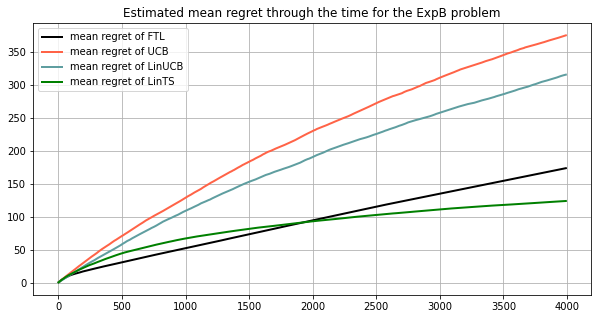

In [ ]:
strategy0 = FTL(K)
strategy1 = UCB(K,alpha)
strategy2 = LinUCB(X,beta_heuri)
strategy3 = LinTS(X,nu)

plt.figure(figsize=(10,5))
RunExpes([strategy0,strategy1,strategy2,strategy3],ExpB,Nexp,T,10,"off")
plt.title('Estimated mean regret through the time for the ExpB problem');

#### We end up with exactly the same situation than before. This is rather expected since we use two functions that are approximately equals to $\sum x_i$ when the $x_i$ are all close to 0.

#### So, we see that the LinTS algorithm could still be of great help even in situations where we have non linear features. If we think about it, if we have a function enough smooth around 0, we could approximate it locally as a linear function using the first-order Taylor approximation. Hence, it would not be a surprise to see that the LinTS performs well in general learning the tangent hyperplane of smooth reward function around 0. Hence it can be considered as a baseline for the MAB problem in general. *(if there is a bias, we can add an extra dimension to $\theta$ and add a 1 to the context vectors)*

#### Also, sometimes it may be possible to find and apply a feature map $\Phi$ to the features, such that the problem becomes linear in $\theta$. In that case, with very small modifications on our strategies (using $\Phi(x)$ instead of $x$ in the computations), we end up with a strategy potentially as efficient as the ones we know. 
 
##### Now, if we work with complex non-linear functions, such as very irregular functions, that should be an other story. We should not expect a good behaviour of the LinTS strategy in that situation. We can try it using for instance : $f_3(x) = \dfrac{1}{d}\sum_i sin(\frac{1}{x_i})$ .



In [ ]:
#Generation of normalized features - ||x|| <= 1
X = torch.randn((K,d))
norms=torch.Tensor([torch.norm(x) for x in X])
X=X/torch.max(norms).item()

TrickyB=TrickyBandit(X)

# print the means of the best two arms
print(np.sort(TrickyB.means)[-5:])

# with open(f'X_{K}_{d}_tricky.pickle', 'wb') as setting:
#     pickle.dump(X, setting)

[0.17192369 0.26097407 0.30493665 0.43033113 0.46744347]


In [21]:
# load the pickle file

with open(f'X_{K}_{d}_tricky.pickle', 'rb') as setting:
    X=pickle.load(setting)
    TrickyB=TrickyBandit(X)
    #We display the means of the arms by ascending order
    print(f'Contextual MAB K={K} d={d}')
    print('\n')
    print('TrickyB')
    print(np.sort(TrickyB.means))
    print('\n')

Contextual MAB K=20 d=10


TrickyB
[-0.44734463 -0.33448741 -0.32692638 -0.32630226 -0.24421096 -0.20514838
 -0.19850866 -0.18169764 -0.04935824 -0.03006557 -0.01658692  0.00513038
  0.01884056  0.16260917  0.16533993  0.17192374  0.26097408  0.30493665
  0.43033114  0.46744344]




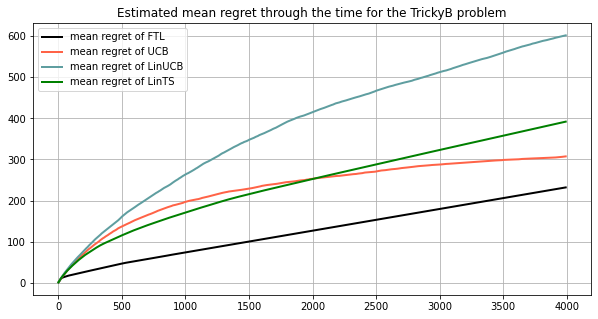

In [ ]:
strategy0 = FTL(K)
strategy1 = UCB(K,alpha)
strategy2 = LinUCB(X,beta_heuri)
strategy3 = LinTS(X,nu)

plt.figure(figsize=(10,5))
RunExpes([strategy0,strategy1,strategy2,strategy3],TrickyB,Nexp,T,10,"off")
plt.title('Estimated mean regret through the time for the TrickyB problem');

#### This time, as expected, the LinTS does not perform well in such situation. The FTL algorithm, which doesn't use the features performs better.

#### So how can we ensure a good TS strategy in the general case ? One solution could be to use the power of deep learning  as suggested by the authors of the article studied. For justifying this idea, we are going to test to what extent a neural network (and more precisely a MLP) can help us for estimating (bounded) mean rewards.

## II - To what extent an MLP architecture can help for estimating mean rewards ?

The authors choose to exploit the power of neural networks for approximating the mean reward function $h$. By assumption, this function can be any bounded function normalized to be lower than 1. 

In this part, we propose to see briefly how well we can approximate h with a neural network presenting a similar structure than the one proposed in the article. 

Let's say for instance that we have collected 1000 context vector $x \in \mathbb R$ and we observed $r(x) = h(x) + \mathcal N(0,1)$ with $h(x)=sin(4x+3)$ at each round.  

We are in the setting proposed by the authors. However, in this section, we are not going to make assumptions on the contexts $x$ except that they comes from a distribution $\mathcal N(0,2)$ for instance in order to simulate a kind of randomness.

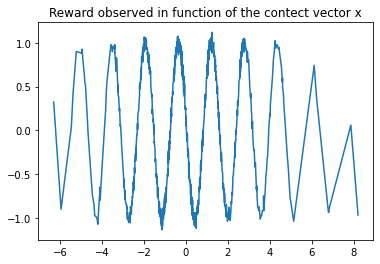

In [ ]:
a=lambda x: np.sin(4*x+3)
h=np.vectorize(a)

#Reproducibility
torch.manual_seed(0)
np.random.seed(0)

dataset=2*torch.randn(1000)

X=torch.sort(dataset)[0]
Y=h(X.numpy())+0.05*np.random.normal(size=1000)

X=X.reshape(-1,1)
Y=torch.from_numpy(Y).view(-1,1)

plt.plot(X,Y)
plt.title('Reward observed in function of the contect vector x');

#### Let's define now an MLP using ReLU activation function

In [ ]:
class MLP(nn.Module):
    def __init__(self,hiddens=[10,20,30,40,50,60,70,80,90,100]):
        super().__init__()
        self.hiddens=hiddens
        self.modules=[nn.Linear(1,hiddens[0]),nn.ReLU()]
        for i in range(1,len(hiddens)):
          self.modules.append(nn.Linear(hiddens[i-1],hiddens[i]))
          self.modules.append(nn.ReLU())
     
        self.modules.append(nn.Linear(hiddens[-1],1))

        self.out=nn.Sequential(*self.modules)
        
    def forward(self, x):
        # Pass the input tensor through each of our operations
        return self.out(x)

#### It's time to train this neural network. For that we are going to use the Adam optimizer and the MSE for our loss function.

In [ ]:
#We are going to take the MSELoss as our loss function and the famous Adam optimizer
criterion = torch.nn.MSELoss() 
my_model = MLP() 
optimizer = torch.optim.Adam(my_model.parameters()) 

for epoch in range(5001): 
    # Forward pass: Compute predicted y by passing  
    # x to the model 
    pred_Y = my_model(X.float())
  
    # Compute and print loss 
    loss = criterion(pred_Y, Y.float()) 
  
    # Zero gradients, perform a backward pass,  
    # and update the weights. 
    optimizer.zero_grad() 
    loss.backward() 
    optimizer.step() 
    if epoch%1000==0:
        print(f"epoch {epoch}, loss {round(loss.item(),4)}")

epoch 0, loss 0.511
epoch 1000, loss 0.0038
epoch 2000, loss 0.0023
epoch 3000, loss 0.0028
epoch 4000, loss 0.0021
epoch 5000, loss 0.0022


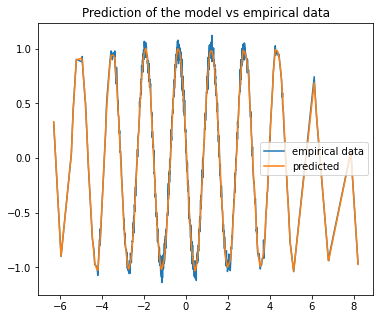

In [ ]:
plt.figure(figsize=(6,5))
pred_Y= my_model(X.float())
plt.plot(X,Y,label='empirical data')
plt.plot(X,pred_Y.detach().numpy(),label='predicted')
plt.title("Prediction of the model vs empirical data")
plt.legend();

As we can observe, the regression seems to be great as expected. We end up with a predictor which approximates h as a sequence of broken lines. Nevertheless, if we have a context vector outside of the training range [-6,6], we should have a poor prediction since the network hasn't something learn something outside of this range.

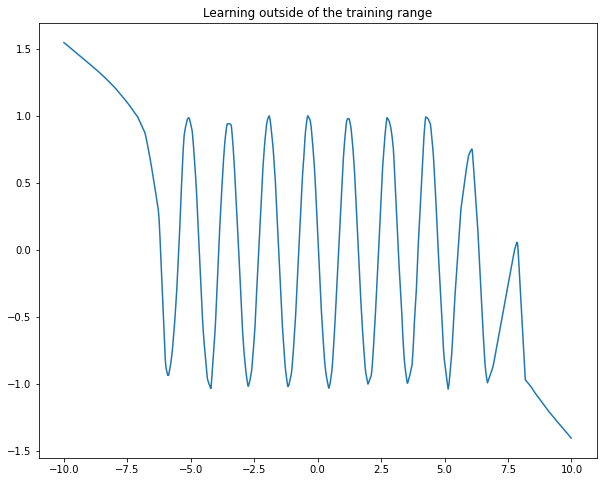

In [ ]:
plt.figure(figsize=(10,8))
X1=np.arange(-10,10,0.01)
X1=torch.from_numpy(X1).view(-1,1)
pred_Y= my_model(X1.float())

plt.plot(X1,pred_Y.detach().numpy(),label='predicted')
plt.title('Learning outside of the training range');

One solution to that problem could simply to normalize the context vectors so that they belong to a certain range.

Now, if we had less contexts, the regression will be undoubtedly poor. Let's say for instance that we are in a problem with 20 fixed arms associating to the same contexts $x_k$. In that case, we technically have access to little information about the shape of the mean reward function. However, the goal of a multi-armed bandit problem is to be able to identify the arm which enables to obtain the largest reward in the long term. In that situation, it is not really a problem to have a poor prediction for the mean reward as long as we still succeed in capturing the best arm.



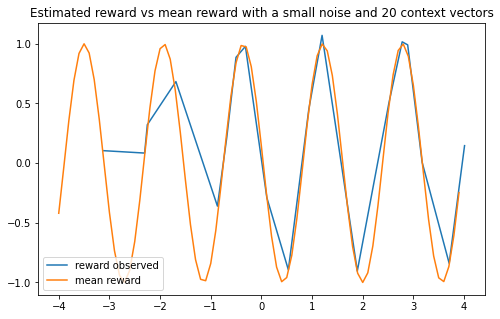

In [ ]:
a=lambda x: np.sin(4*x+3)
h=np.vectorize(a)


#Reproducibility
torch.manual_seed(0)
np.random.seed(0)


dataset=2*torch.randn(20)

X=torch.sort(dataset)[0]
Y=h(X.numpy())+0.05*np.random.normal(size=20)

X=X.reshape(-1,1)
X1=torch.arange(-4,4,0.1)

Y=torch.from_numpy(Y).view(-1,1)
Y1=h(X1.numpy())

plt.figure(figsize=(8,5))
plt.plot(X,Y,label='reward observed')
plt.plot(X1,Y1,label='mean reward')
plt.title('Estimated reward vs mean reward with a small noise and 20 context vectors')
plt.legend();

We see that the order of the rewards are preserved (when $r_i < r_k$, we have also $\tilde{r_i} < \tilde{r_k}$) hence, learning the blue curve should lead to the good solution to our problem. Moreover, this curve will be much more easy to learn for the network since even us we can understand how to decompose it into a set of broken lines. 

Now, if noise is too important, we could end up with wrong predictions.

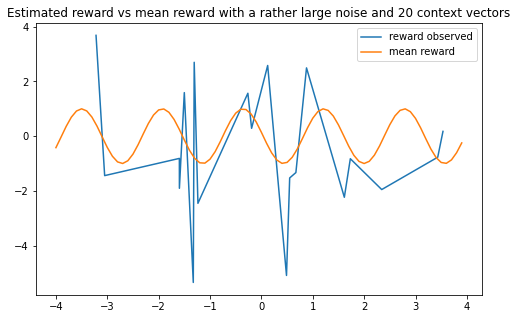

In [ ]:
a=lambda x: np.sin(4*x+3)
h=np.vectorize(a)

#Reproducibility
torch.manual_seed(1)
np.random.seed(1)

dataset=2*torch.randn(20)

X=torch.sort(dataset)[0]
Y=h(X.numpy())+2*np.random.normal(size=20)

X=X.reshape(-1,1)
X1=torch.arange(-4,4,0.1)

Y=torch.from_numpy(Y).view(-1,1)
Y1=h(X1.numpy())

plt.figure(figsize=(8,5))
plt.plot(X,Y,label='reward observed')
plt.plot(X1,Y1,label='mean reward')
plt.title('Estimated reward vs mean reward with a rather large noise and 20 context vectors')
plt.legend();

This time, the order is not preserved, the best arm is not the one providing the best observed reward and learning that approximate curve could lead us to wrong conclusions.

In practice, when we work in the MAB setting, we assume that the noise is sufficiently low so that we can potentially solve the problem. 

Now, in the scenario of the authors, we are working in a changing environment in which the context vectors are updated at each round and so the best arm. In that case we really need a good approximation of h, and if we do many steps we can find a satisfying one and solve the problem in the long term. 

In order to ensure a good regret guarantee, the authors have proposed two assumptions :

- Each context vector should be normalized such that its norm is 1
- There is a symmetry in the coefficients of each context vector $[x]_j = [x]_{j+d/2}$

As they explained, it is very easy to transform any vector so that it meets these conditions. We can note that such a vector live in a space of dimension $d$ with $d$ even. Moreover, the normalization to 1 seems to be a good idea since as we have seen an MLP is very good for approximating a bounded function **in a given range**.

Unfortunately, meeting these assumptions imply that we can't plot as we did before the estimated reward against the real one. Indeed :

- In dimension 1, if we do the transformation of our contexts  we end up with 2d vectors, each one being equals to $(\frac{1}{\sqrt2},\frac{1}{\sqrt2})$ or $(\frac{-1}{\sqrt2},\frac{-1}{\sqrt2})$ and hence, we lose many information we had before and this is not a good situation.
- In dimension 2, if we do the transformation of our context vectors we end up with 4d vectors that we can't represent easily.


#### Now, we can observe how the network react to a stepwise continuous function for instance.

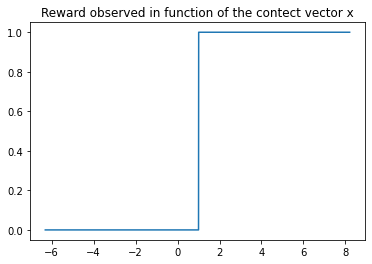

In [ ]:
def f(x):
    if x<1:
        return 0
    else:
       return 1

h=np.vectorize(f)

#Reproducibility
torch.manual_seed(0)
np.random.seed(0)

dataset=2*torch.randn(1000)

X=torch.sort(dataset)[0]
Y=h(X.numpy())

X=X.reshape(-1,1)
Y=torch.from_numpy(Y).view(-1,1)

plt.plot(X,Y)
plt.title('Reward observed in function of the contect vector x');

In [ ]:
#We are going to take the MSELoss as our loss function and the famous Adam optimizer
criterion = torch.nn.MSELoss() 
my_model = MLP(hiddens=[20,20]) 
optimizer = torch.optim.Adam(my_model.parameters()) 

for epoch in range(1000): 
    # Forward pass: Compute predicted y by passing  
    # x to the model 
    pred_Y = my_model(X.float())
  
    # Compute and print loss 
    loss = criterion(pred_Y, Y.float()) 
  
    # Zero gradients, perform a backward pass,  
    # and update the weights. 
    optimizer.zero_grad() 
    loss.backward() 
    optimizer.step() 
    if epoch%100==0:
        print(f"epoch {epoch}, loss {round(loss.item(),4)}")

epoch 0, loss 0.2786
epoch 100, loss 0.0455
epoch 200, loss 0.03
epoch 300, loss 0.0215
epoch 400, loss 0.0164
epoch 500, loss 0.0121
epoch 600, loss 0.0082
epoch 700, loss 0.0057
epoch 800, loss 0.0046
epoch 900, loss 0.0038


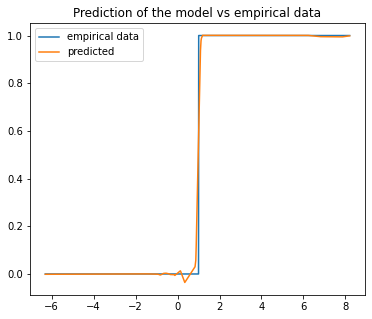

In [ ]:
plt.figure(figsize=(6,5))
pred_Y= my_model(X.float())
plt.plot(X,Y,label='empirical data')
plt.plot(X,pred_Y.detach().numpy(),label='predicted')
plt.title("Prediction of the model vs empirical data")
plt.legend();

As we could expect, the learning is really good. Hence, this could be indeed a good idea to use an MLP for approximating a reward step-wise continuous. 


#### We can be also tempted to see if an MLP can also help us to estimate a tricky mean reward $r(x) = sin(\frac{1}{x})$. Indeed, in the part I, we have shown that with a reward of this form, the LinTS wasn't optimal anymore so maybe using a neural network could be the solution to this problem.

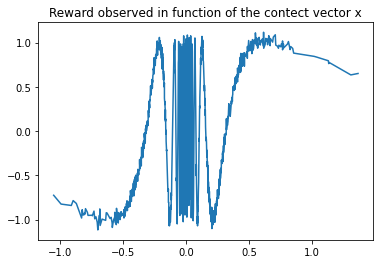

In [ ]:
def f(x):
    return np.sin(1/x)

h=np.vectorize(f)

#Reproducibility
torch.manual_seed(0)
np.random.seed(0)

dataset=(1/3)*torch.randn(1000)

X=torch.sort(dataset)[0]
Y=h(X.numpy()) + 0.05*np.random.normal(size=(1000))

X=X.reshape(-1,1)
Y=torch.from_numpy(Y).view(-1,1)

plt.plot(X,Y)
plt.title('Reward observed in function of the contect vector x');

#### We observe a very irregular behaviour nearby zero. Around that precise location, we could expect from the neural network to struggle with the learning of h.

In [ ]:
#We are going to take the MSELoss as our loss function and the famous Adam optimizer
criterion = torch.nn.MSELoss() 
my_model = MLP(hiddens=[20,40,60,80,100,200]) 
optimizer = torch.optim.Adam(my_model.parameters()) 

for epoch in range(20000): 
    # Forward pass: Compute predicted y by passing  
    # x to the model 
    pred_Y = my_model(X.float())
  
    # Compute and print loss 
    loss = criterion(pred_Y, Y.float()) 
  
    # Zero gradients, perform a backward pass,  
    # and update the weights. 
    optimizer.zero_grad() 
    loss.backward() 
    optimizer.step() 
    if epoch%1000==0:
        print(f"epoch {epoch}, loss {round(loss.item(),4)}")

epoch 0, loss 0.5256
epoch 1000, loss 0.1507
epoch 2000, loss 0.1383
epoch 3000, loss 0.1352
epoch 4000, loss 0.1052
epoch 5000, loss 0.0983
epoch 6000, loss 0.0886
epoch 7000, loss 0.0872
epoch 8000, loss 0.0825
epoch 9000, loss 0.0778
epoch 10000, loss 0.0774
epoch 11000, loss 0.0704
epoch 12000, loss 0.069
epoch 13000, loss 0.0676
epoch 14000, loss 0.0666
epoch 15000, loss 0.067
epoch 16000, loss 0.0846
epoch 17000, loss 0.0649
epoch 18000, loss 0.0633
epoch 19000, loss 0.0631


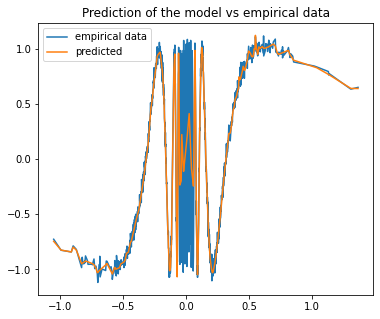

In [ ]:
plt.figure(figsize=(6,5))
pred_Y= my_model(X.float())
plt.plot(X,Y,label='empirical data')
plt.plot(X,pred_Y.detach().numpy(),label='predicted')
plt.title("Prediction of the model vs empirical data")
plt.legend();

#### As expected, the learning of $h$ in the local neighbouring of 0 is really tricky but this is perfectly normal. However, the MLP succeed in capturing the shape of the function outside this local neighbouring of 0 so it should help to have better results coupled with the Thompson Sampling strategy.

#### However, the authors used an architecture where there is no bias and we think that could prevent the model from learning $h$ in general. The bias term is important and help to capture more complex pattern. In dimension 1, we can see it easily. Hence we don't exactly understand that choice. 

#### Let's observe how will react our different architectures using no bias in the linear layers for different reward functions.


In [ ]:
class MLPnobias(nn.Module):
    def __init__(self,hiddens=[10,20,30,40,50,60,70,80,90,100]):
        super().__init__()
        self.hiddens=hiddens
        self.modules=[nn.Linear(1,hiddens[0],bias=False),nn.ReLU()]
        for i in range(1,len(hiddens)):
          self.modules.append(nn.Linear(hiddens[i-1],hiddens[i],bias=False))
          self.modules.append(nn.ReLU())
     
        self.modules.append(nn.Linear(hiddens[-1],1,bias=False))

        self.out=nn.Sequential(*self.modules)
        
    def forward(self, x):
        # Pass the input tensor through each of our operations
        return self.out(x)

#### For instance, we could keep the function $x \mid\rightarrow \sin(\frac1x)$ and try with $x \mid \rightarrow x(x-1)(x+1)$.

In [ ]:
def generate_noisy_data(f,noise=0.05):

    h=np.vectorize(f)
    
    #Reproducibility
    torch.manual_seed(0)
    np.random.seed(0)
    
    dataset=(1/3)*torch.randn(1000)
    
    X=torch.sort(dataset)[0]
    Y=h(X.numpy()) + 0.05*np.random.normal(size=(1000))
    
    X=X.view(-1,1)
    Y=torch.from_numpy(Y).view(-1,1)
    
    return X,Y

In [ ]:
X,Y = generate_noisy_data(lambda x:np.sin(1/x),noise=0.05)

In [ ]:
#We are going to take the MSELoss as our loss function and the famous Adam optimizer
criterion = torch.nn.MSELoss() 
my_model = MLPnobias(hiddens=[20,40,60,80,100,200]) 
optimizer = torch.optim.Adam(my_model.parameters()) 

for epoch in range(5000): 
    # Forward pass: Compute predicted y by passing  
    # x to the model 
    pred_Y = my_model(X.float())
  
    # Compute and print loss 
    loss = criterion(pred_Y, Y.float()) 
  
    # Zero gradients, perform a backward pass,  
    # and update the weights. 
    optimizer.zero_grad() 
    loss.backward() 
    optimizer.step() 
    if epoch%1000==0:
        print(f"epoch {epoch}, loss {round(loss.item(),4)}")

epoch 0, loss 0.524
epoch 1000, loss 0.4393
epoch 2000, loss 0.4393
epoch 3000, loss 0.4393
epoch 4000, loss 0.4393


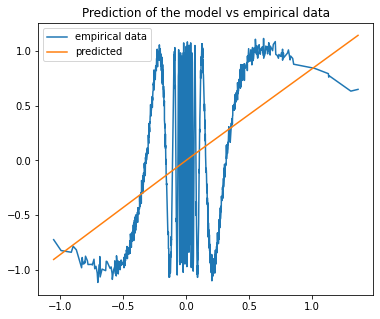

In [ ]:
plt.figure(figsize=(6,5))
pred_Y= my_model(X.float())
plt.plot(X,Y,label='empirical data')
plt.plot(X,pred_Y.detach().numpy(),label='predicted')
plt.title("Prediction of the model vs empirical data")
plt.legend();

In [ ]:
X,Y = generate_noisy_data(lambda x:x*(x-1)*(x+1),noise=0.001)

In [ ]:
#We are going to take the MSELoss as our loss function and the famous Adam optimizer
criterion = torch.nn.MSELoss() 
my_model = MLPnobias(hiddens=[20,40,60,80,100,200]) 
optimizer = torch.optim.Adam(my_model.parameters()) 

for epoch in range(5000): 
    # Forward pass: Compute predicted y by passing  
    # x to the model 
    pred_Y = my_model(X.float())
  
    # Compute and print loss 
    loss = criterion(pred_Y, Y.float()) 
  
    # Zero gradients, perform a backward pass,  
    # and update the weights. 
    optimizer.zero_grad() 
    loss.backward() 
    optimizer.step() 
    if epoch%1000==0:
        print(f"epoch {epoch}, loss {round(loss.item(),4)}")

epoch 0, loss 0.0611
epoch 1000, loss 0.0189
epoch 2000, loss 0.0189
epoch 3000, loss 0.0189
epoch 4000, loss 0.0189


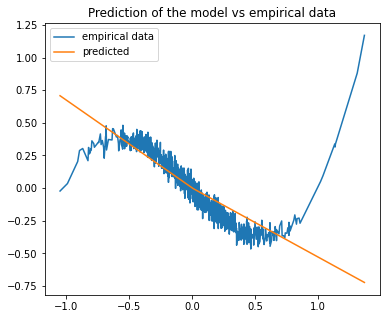

In [ ]:
plt.figure(figsize=(6,5))
pred_Y= my_model(X.float())
plt.plot(X,Y,label='empirical data')
plt.plot(X,pred_Y.detach().numpy(),label='predicted')
plt.title("Prediction of the model vs empirical data")
plt.legend();

#### However, for simple functions it could suffice to train a network with no bias.

In [ ]:
X,Y = generate_noisy_data(lambda x:np.abs(x),noise=0.001)

In [ ]:
#We are going to take the MSELoss as our loss function and the famous Adam optimizer
criterion = torch.nn.MSELoss() 
my_model = MLPnobias(hiddens=[20,40,60,80,100,200]) 
optimizer = torch.optim.Adam(my_model.parameters()) 

for epoch in range(4000): 
    # Forward pass: Compute predicted y by passing  
    # x to the model 
    pred_Y = my_model(X.float())
  
    # Compute and print loss 
    loss = criterion(pred_Y, Y.float()) 
  
    # Zero gradients, perform a backward pass,  
    # and update the weights. 
    optimizer.zero_grad() 
    loss.backward() 
    optimizer.step() 
    if epoch%1000==0:
        print(f"epoch {epoch}, loss {round(loss.item(),4)}")

epoch 0, loss 0.1209
epoch 1000, loss 0.0024
epoch 2000, loss 0.0024
epoch 3000, loss 0.0024


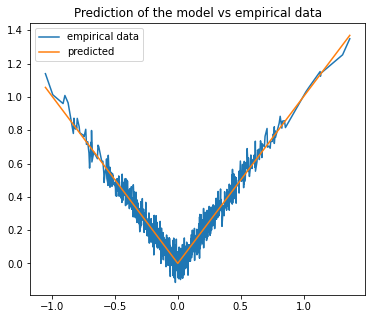

In [ ]:
plt.figure(figsize=(6,5))
pred_Y= my_model(X.float())
plt.plot(X,Y,label='empirical data')
plt.plot(X,pred_Y.detach().numpy(),label='predicted')
plt.title("Prediction of the model vs empirical data")
plt.legend();

#### But, if we work now with something slighlty different like |x-1|, it will fail !

In [ ]:
X,Y = generate_noisy_data(lambda x:np.abs(x-1),noise=0.001)

In [ ]:
#We are going to take the MSELoss as our loss function and the famous Adam optimizer
criterion = torch.nn.MSELoss() 
my_model = MLPnobias(hiddens=[20,40,60,80,100,200]) 
optimizer = torch.optim.Adam(my_model.parameters()) 

for epoch in range(4000): 
    # Forward pass: Compute predicted y by passing  
    # x to the model 
    pred_Y = my_model(X.float())
  
    # Compute and print loss 
    loss = criterion(pred_Y, Y.float()) 
  
    # Zero gradients, perform a backward pass,  
    # and update the weights. 
    optimizer.zero_grad() 
    loss.backward() 
    optimizer.step() 
    if epoch%1000==0:
        print(f"epoch {epoch}, loss {round(loss.item(),4)}")

epoch 0, loss 1.0969
epoch 1000, loss 0.3694
epoch 2000, loss 0.3694
epoch 3000, loss 0.3694


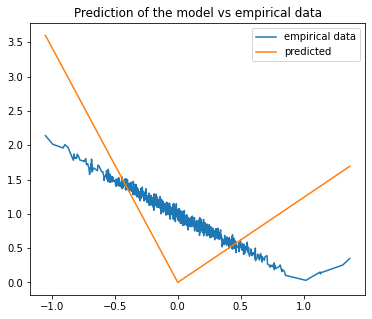

In [ ]:
plt.figure(figsize=(6,5))
pred_Y= my_model(X.float())
plt.plot(X,Y,label='empirical data')
plt.plot(X,pred_Y.detach().numpy(),label='predicted')
plt.title("Prediction of the model vs empirical data")
plt.legend();

#### Hence, we propose to test the behaviour of the NeuralTS strategy of the authors VS the behaviour of the same architecture but using biases in several experiments.

## III - The NeuralTS strategy

Here, we are going to follow the scenario of the authors.

We call $K$ the number of possible arms per round and $T$ the number of rounds (also called the **horizon time**). Now, we imagine a situation where the reward $r_{t,k}$ obtained at time $t$, pulling the $k$-th arm verify :

$$\forall_{1 \leq k \leq K}  \ \ \forall_{1 \leq t \leq T} r_{t, k}=h\left(\mathbf{x}_{t, k}\right)+\xi_{t, k}, \quad \text{with} \quad\left|h\left(\mathbf{x}_{t, k}\right)\right| \leq 1$$
    
where $h$ could be  **any bounded function** and $\xi_{t, k}$ is a noise meeting the condition : 


$$\forall \lambda \in \mathbb{R} \ \ \mathbb{E}\left[\exp \left(\lambda \xi_{t, k}\right) \mid \xi_{1: t-1, k}, \mathbf{x}_{1: t, k}\right] \leq \exp \left(\lambda^{2} R^{2}\right)$$ 

Here we will consider a gaussian noise $\mathcal N(0,\sigma^2)$ with $\sigma=0.001$ for instance

Now, we are going to build features that met the assumptions of the authors :

$$\forall T \ \  \forall k \ \ ||x_{t,k}||_2 = 1 \ \ \text{and} \ \ [x_{t,k}]_j=[x_{t,k}]_{j+d/2}$$ 

For our simulations, we can take for example $h_1(x)=\frac{1}{d}\sum_{i=1}^{d} \sin({x_i})$  and $h_2(x)=\frac{1}{d}\sum_{i=1}^{d} \sin(\dfrac{1}{x_i})$  and $h_3(x)=\frac{1}{d}\sum_{i=1}^{d} |x_i|$ with $\xi \sim \mathcal N(0,\sigma^2I_d)$ 

Please note that the code for this part can be founded in our library `NeuralTS.py`. 

**The NeuralTS can take a very long time to train. Hence, we decided here to restrict ourself to $d=10$, $K=10$, $T=500$ and we computed the mean regret over only 20 runs**






In [33]:
K=10
d=10
sigma=10**(-3)
nu=sigma
beta_heuri= lambda t:sigma*np.sqrt(d*log(t))
alpha=2*(sigma**2) 
Nexp=20
T=500
X=generate_contexts(K,d)

### **1 - The case where we work with $K$ fixed arms**

Here, we are going to study the efficiency of the NeuralTS algorithm in the classic case where the arms are fixed.

We have implemented the NeuralTS algorithm following cautiously the description of the authors. The algorithm was rather well described but we had to understood by ourself what was behind $g$ and how they derived their formulas. All of that is precised in the report. We proposed also a variant where we added the bias term in the linear layers.

In order to make it works, we have used a neural network with `pytorch` and the libraries of our teacher Emilie Kaufmann for simulating bandit problems. 


In [ ]:
SinB=SinBandit(X,sigma=sigma)
TrickyB=TrickyBandit(X,sigma=sigma)
AbsB=AbsBandit(X,sigma=sigma)

# print the means of the best five arms
print(np.sort(SinB.means)[-5:])
print(np.sort(TrickyB.means)[-5:])
print(np.sort(AbsB.means)[-5:])

# with open(f'X_{K}_{d}_NTS.pickle', 'wb') as setting:
#     pickle.dump(X, setting)

[0.11217999 0.15465047 0.1941648  0.22325604 0.25751176]
[0.17028706 0.19000115 0.3147851  0.37083631 0.42812557]
[0.26431904 0.27265098 0.2760133  0.27892461 0.30031767]


In [34]:
# load the pickle file

with open(f'X_{K}_{d}_NTS.pickle', 'rb') as setting:
    X=pickle.load(setting)
    SinB=SinBandit(X,sigma=sigma)
    TrickyB=TrickyBandit(X,sigma=sigma)
    AbsB=AbsBandit(X,sigma=sigma)
    #We display the means of the arms by ascending order
    print(f'Contextual MAB K={K} d={d}')
    print('\n')
    print('SinB')
    print(np.sort(np.round(SinB.means,2)))
    print('\n')
    print('TrickyB')
    print(np.sort(np.round(TrickyB.means,2)))
    print('\n')
    print('AbsB')
    print(np.sort(np.round(AbsB.means,2)))

Contextual MAB K=10 d=10


SinB
[-0.19 -0.14  0.02  0.06  0.09  0.11  0.15  0.19  0.22  0.26]


TrickyB
[-0.53 -0.41 -0.41 -0.26 -0.03  0.17  0.19  0.31  0.37  0.43]


AbsB
[0.2  0.21 0.25 0.26 0.26 0.26 0.27 0.28 0.28 0.3 ]


In [35]:
## loss function for the NeuralTS
def criterion(estimated_reward,reward,m,reg,theta,theta_0):
    return 0.5*torch.sum(torch.square(estimated_reward-reward))+0.5*m*reg*torch.square(torch.norm(theta-theta_0))

#### Now let's see how well can perform the NeuralTS in our two situations.


We have chosen a simple architecture for the mean estimator using $m=20$ and $L=3$

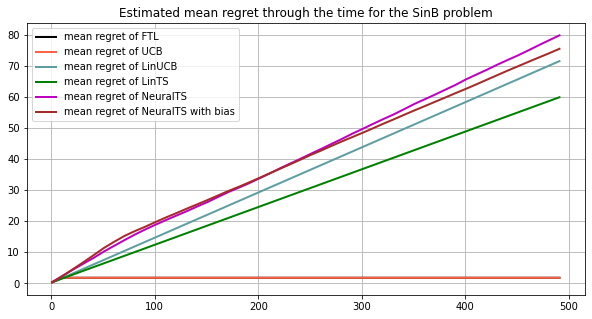

In [36]:
strategy0 = FTL(K)
strategy1 = UCB(K,alpha)
strategy2 = LinUCB(X,beta_heuri)
strategy3 = LinTS(X,nu)
strategy4 = NeuralTS(X,nu=1,m=20,L=3,estimator=MeanEstimator,criterion=criterion)
strategy5 = NeuralTS(X,nu=1,m=20,L=3,estimator=MeanEstimatorWithBias,criterion=criterion,name='NeuralTS with bias')

plt.figure(figsize=(10,5))
RunExpes([strategy0,strategy1,strategy2,strategy3,strategy4,strategy5],SinB,Nexp,T,10,"off")
plt.title('Estimated mean regret through the time for the SinB problem');

##### It seems that the two NeuralTS are performing worse than the classical strategies. Let's see know that will be the situation with our tricky bandit !

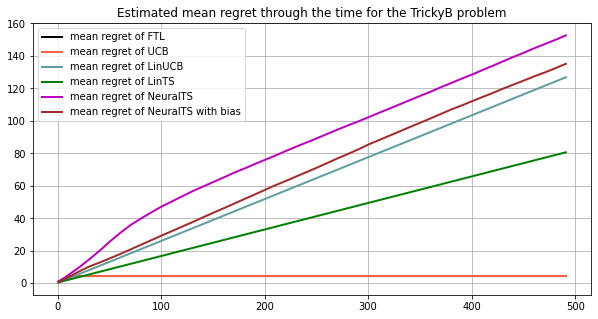

In [37]:
strategy0 = FTL(K)
strategy1 = UCB(K,alpha)
strategy2 = LinUCB(X,beta_heuri)
strategy3 = LinTS(X,nu)
strategy4 = NeuralTS(X,nu=1,m=20,L=3,estimator=MeanEstimator,criterion=criterion)
strategy5 = NeuralTS(X,nu=1,m=20,L=3,estimator=MeanEstimatorWithBias,criterion=criterion,name='NeuralTS with bias')

plt.figure(figsize=(10,5))
RunExpes([strategy0,strategy1,strategy2,strategy3,strategy4,strategy5],TrickyB,Nexp,T,10,"off")
plt.title('Estimated mean regret through the time for the TrickyB problem');

#### Again both NeuralTS are the two worst strategies but the one with the bias is still better than the one without. Hence, it's interesting to see that nothing is fixed when we solve different bandit problems and that even in the case where we have little information about the arms, classic strategies can still perform well. 

#### Let's see now the behaviour of the strategies with the AbsBandit

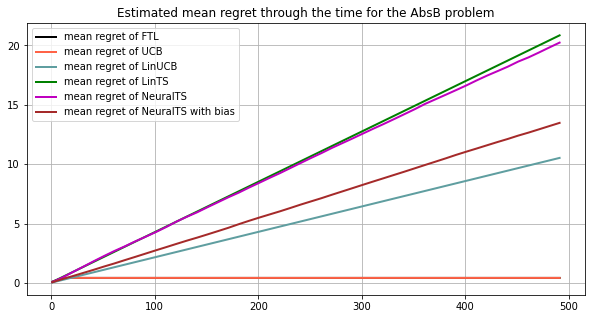

In [38]:
strategy0 = FTL(K)
strategy1 = UCB(K,alpha)
strategy2 = LinUCB(X,beta_heuri)
strategy3 = LinTS(X,nu)
strategy4 = NeuralTS(X,nu=1,m=20,L=3,estimator=MeanEstimator,criterion=criterion)
strategy5 = NeuralTS(X,nu=1,m=20,L=3,estimator=MeanEstimatorWithBias,criterion=criterion,name='NeuralTS with bias')

plt.figure(figsize=(10,5))
RunExpes([strategy0,strategy1,strategy2,strategy3,strategy4,strategy5],AbsB,Nexp,T,10,"off")
plt.title('Estimated mean regret through the time for the AbsB problem');

##### This time, both NeuralTS are better than the LinTS and the one with the bias is far better. However, these two strategies stay worse than the FTL and the UCB which don't use the features !


### Globally, we observe that the FTL and the UCB are in fact often among the best strategies. This poor behaviour of NeuralTS with $K$ armed fixed was expected by the authors in their conclusion.

#### Why are we observing such results for the NeuralTS ? We could potentially explain it by the fact that we are trying to predict $h_1$, $h_2$ and $h_3$ using only 10 points living in dimension $d=10$. Because of that, the neural network does not succeed in capturing $h_1$ and $h_2$ because he does not have enough information to make a good guess.

#### Now, if we consider a situation where the arms are updated at each round, it could change the story.

### **2 - The case where we work with $K$ changing arms at each round**

Remark : In this case, the FTL and the UCB strategies are out of context since their goal was to find the best arm among K fixed arms by construction. Here these arms are changing and so the best one at each round.


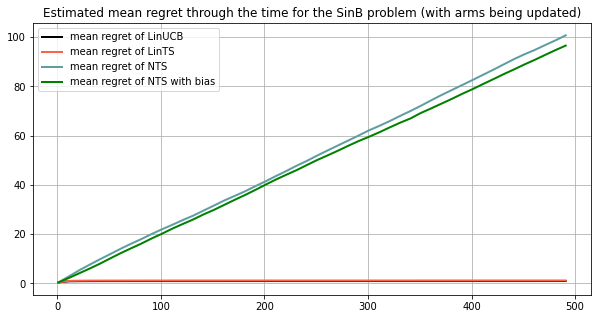

In [39]:
strategy0 = LinUCB(X=X,beta=beta_heuri,bandit_generator=SinBandit,sigma=sigma)
strategy1 = LinTS(X=X,nu=sigma,bandit_generator=SinBandit,sigma=sigma)
strategy2 = NeuralTS(X=X,nu=1,m=20,L=3,estimator=MeanEstimator,criterion=criterion,bandit_generator=SinBandit,sigma=sigma,name='NTS')
strategy3 = NeuralTS(X=X,nu=1,m=20,L=3,estimator=MeanEstimatorWithBias,criterion=criterion,bandit_generator=SinBandit,sigma=sigma,name='NTS with bias')
SinB=strategy0.new_MAB()

plt.figure(figsize=(10,5))
RunExpes([strategy0,strategy1,strategy2,strategy3],SinB,Nexp,T,10,"off",update=True)
plt.title('Estimated mean regret through the time for the SinB problem (with arms being updated)');

#### This time, unfortunately the two NeuralTS strategies aren't performing well. It's more difficult to understand since we would expect that they have learned something with (4000*10=40000) points. 

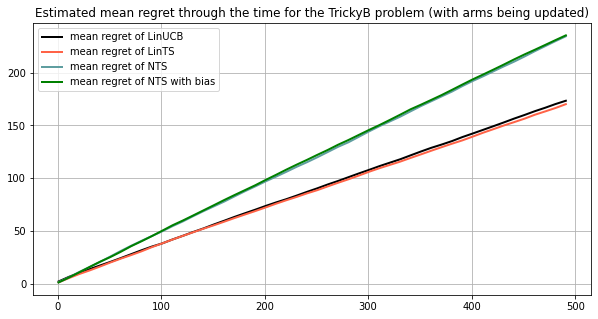

In [40]:
strategy0 = LinUCB(X=X,beta=beta_heuri,bandit_generator=TrickyBandit,sigma=sigma)
strategy1 = LinTS(X=X,nu=sigma,bandit_generator=TrickyBandit,sigma=sigma)
strategy2 = NeuralTS(X=X,nu=1,m=20,L=3,estimator=MeanEstimator,criterion=criterion,bandit_generator=TrickyBandit,sigma=sigma,name='NTS')
strategy3 = NeuralTS(X=X,nu=1,m=20,L=3,estimator=MeanEstimatorWithBias,criterion=criterion,bandit_generator=TrickyBandit,sigma=sigma,name='NTS with bias')
TrickyB=strategy0.new_MAB()

plt.figure(figsize=(10,5))
RunExpes([strategy0,strategy1,strategy2,strategy3],TrickyB,Nexp,T,10,"off",update=True)
plt.title('Estimated mean regret through the time for the TrickyB problem (with arms being updated)');

#### In this situation, we see that all the strategies have a linear regret and the linear ones are still the best. That being said, this bad performance could be explained by the fact that $h_2$ is really not predictible around 0 for a simple neural network.

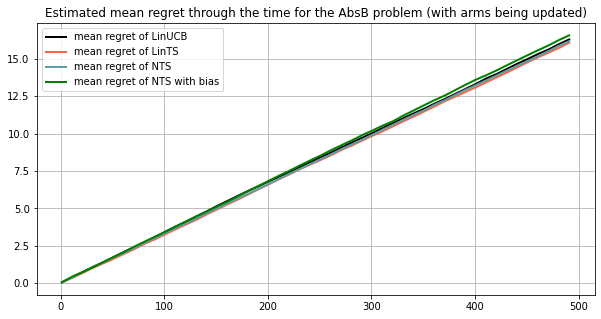

In [42]:
strategy0 = LinUCB(X=X,beta=beta_heuri,bandit_generator=AbsBandit,sigma=sigma)
strategy1 = LinTS(X=X,nu=sigma,bandit_generator=AbsBandit,sigma=sigma)
strategy2 = NeuralTS(X=X,nu=1,m=20,L=3,estimator=MeanEstimator,criterion=criterion,bandit_generator=AbsBandit,sigma=sigma,name='NTS')
strategy3 = NeuralTS(X=X,nu=1,m=20,L=3,estimator=MeanEstimatorWithBias,criterion=criterion,bandit_generator=AbsBandit,sigma=sigma,name='NTS with bias')
AbsB=strategy0.new_MAB()

plt.figure(figsize=(10,5))
RunExpes([strategy0,strategy1,strategy2,strategy3],AbsB,Nexp,T,10,"off",update=True)
plt.title('Estimated mean regret through the time for the AbsB problem (with arms being updated)');

#### This time, we have very similar regret for all the strategies ! It's an improvement compared to the previous situations but it's still curious to not see the NeuralTS outperform the other algorithms.

Let us make some remarks here to conclude what we have found :

- Surprisingly, the LinearTS and LinearUCB can perform well in situations where the mean reward function is not linear.

- We have seen also that a neural network can be really good for estimating a bounded function but, yet, we didn't succeed in exploiting this ability in the NeuralTS algorithm. In fact, it seems that to make it properly work, we have to tune carefully all its parameters ($\lambda$,$\nu$,L,m). Sometimes, testing randomly non linear MAB problems, we succeed in making it efficient but it was not a long term behaviour in the sense that running multiple time the strategy didn't lead us to good results every time. The tricky thing here is that the network takes a long time to train and hence, it's really difficult to properly tune the parameters given the time needed to check that they work for a long term behaviour. Also, we don't exclude the possibility of a mistake in the code even if it has been revised multiple times.

### IV - Classification problem

At last, we propose to test a classification problem with the NeuralTS strategy just like the authors. We took the dataset 'Adult' for that, one of those they chosen. Here, we also proposed to normalize the features such that their norms are lower than 1.

In [9]:
from sklearn.datasets import fetch_openml

In [11]:
X, Y = fetch_openml(name='adult', version=1, return_X_y=True)
features_complete = (np.isnan(X).sum(axis=0)) == 0 # features without missing values
X = X[:, features_complete]
Y=pd.factorize(Y)[0]
n, d = X.shape
print(n, d)

X=normalize(X)

48842 11


In [10]:
def normalize(X,ord=2):
    'Normalize an array of vectors dividing each element by the maximal norm'
    norms=[la.norm(X[i],ord=ord) for i in range(len(X))]
    return X/(max(norms))

In [12]:
np.random.seed(1)
np.random.shuffle(X)
np.random.seed(1)
np.random.shuffle(Y)

In [14]:
d=len(X[0])*len(np.unique(Y))
T=4000
Nexp=3
beta_heuri= lambda t:sigma*np.sqrt(d*log(t))

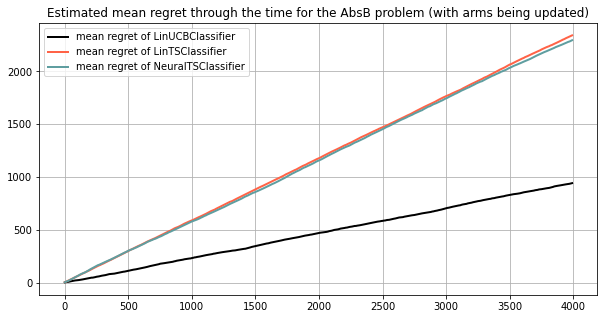

In [15]:
strategy0=LinUCBClassifier(X,Y,beta=beta_heuri,bandit_generator=ClassBandit)
strategy1=LinTSClassifier(X,Y,nu=0.001,bandit_generator=ClassBandit)
strategy2=NeuralTSClassifier(X=X,Y=Y,nu=1,m=100,L=1,reg=1,estimator=MeanEstimator,criterion=criterion,bandit_generator=ClassBandit)
FirstBanditProblem=strategy0.new_MAB()
strategy1.update_features()
strategy2.update_features()
plt.figure(figsize=(10,5))
RunExpes([strategy0,strategy1,strategy2],FirstBanditProblem,Nexp,T,10,"off",update=True)
plt.title('Estimated mean regret through the time for the AbsB problem (with arms being updated)');

#### The NeuralTS classifier behave as good as the LinTS one and both are outperformed by the LinUCB one. Hence, even in the same setting as the authors, we didn't succeed in showing surprising results for the NeuralTS for non-linear rewards.